<a href="https://colab.research.google.com/gist/vereniaes/a7e013e7bb9f5835242f6a30f16670f2/pencit-uas-klasifikasi-biji-kopi-119.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, BatchNormalization, Dropout
from tensorflow.keras import Sequential

import pathlib
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Download dataset from kaggle

In [2]:
# from google.colab import drive
# drive.mount('/gdrive/')
# %cd /gdrive

Install Kaggle

In [3]:
!pip install kaggle

Bikin folder kaggle

In [4]:
! mkdir ~/.kaggle

In [5]:
! cp /content/kaggle.json ~/.kaggle/

Ganti akses file kaggle.json

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

Download dataset dari kaggle

In [7]:
! kaggle datasets download -d gpiosenka/coffee-bean-dataset-resized-224-x-224

100% 144M/144M [00:02<00:00, 87.9MB/s]
100% 144M/144M [00:02<00:00, 59.7MB/s]


Extract file zip dataset

In [8]:
! unzip /content/coffee-bean-dataset-resized-224-x-224.zip

Archive:  /content/coffee-bean-dataset-resized-224-x-224.zip
  inflating: Coffee Bean.csv         
  inflating: test/Dark/dark (1).png  
  inflating: test/Dark/dark (10).png  
  inflating: test/Dark/dark (100).png  
  inflating: test/Dark/dark (11).png  
  inflating: test/Dark/dark (12).png  
  inflating: test/Dark/dark (13).png  
  inflating: test/Dark/dark (14).png  
  inflating: test/Dark/dark (15).png  
  inflating: test/Dark/dark (16).png  
  inflating: test/Dark/dark (17).png  
  inflating: test/Dark/dark (18).png  
  inflating: test/Dark/dark (19).png  
  inflating: test/Dark/dark (2).png  
  inflating: test/Dark/dark (20).png  
  inflating: test/Dark/dark (21).png  
  inflating: test/Dark/dark (22).png  
  inflating: test/Dark/dark (23).png  
  inflating: test/Dark/dark (24).png  
  inflating: test/Dark/dark (25).png  
  inflating: test/Dark/dark (26).png  
  inflating: test/Dark/dark (27).png  
  inflating: test/Dark/dark (28).png  
  inflating: test/Dark/dark (29).png  
  inf

# Directory creation

In [9]:
train_dir = '/content/train'
test_dir = '/content/test'

List semua label yang ada di dataset

In [10]:
data_dir = pathlib.Path("/content/train")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")])) # creating a list of class names from subdirectory
print(class_names)

['Dark' 'Green' 'Light' 'Medium']



Fungsi buat ngeliat gambar

In [11]:
def view_random_image(target_dir, target_class):
  # setting up the image directory
  target_folder = target_dir + target_class

  #get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  #read image and plotting it
  img = mpimg.imread(target_folder + "/" + random_image[0] )
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image shape: {img.shape}")

  return img

Ngeliat tiap gambar yang ada di tiap class

Image shape: (224, 224, 3)
Image shape: (224, 224, 3)
Image shape: (224, 224, 3)
Image shape: (224, 224, 3)


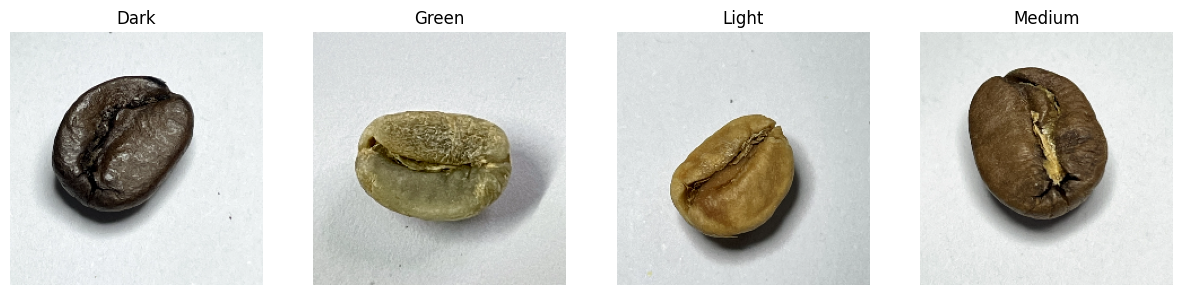

In [12]:
plt.figure(figsize = (15,7))
plt.subplot(1,4,1)
dark_bean_image = view_random_image("/content/train/", "Dark")
plt.subplot(1,4,2)
green_bean_image = view_random_image("/content/train/", "Green")
plt.subplot(1,4,3)
light_bean_image = view_random_image("/content/train/", "Light")
plt.subplot(1,4,4)
medium_bean_image = view_random_image("/content/train/", "Medium")

# Image Preprocessing

Rescale gambar

In [13]:
# Rescale
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255, validation_split=0.2)

Ngebagi dataset jadi train, val dan test

In [14]:

# data transfer from directories to batches
train_data = train_datagen.flow_from_directory(directory = train_dir,
                                               batch_size= 32,
                                               target_size= (224,224),
                                               class_mode = "categorical")

val_data = test_datagen.flow_from_directory(directory = test_dir,
                                               batch_size = 32,
                                               target_size = (224,224),
                                               class_mode = "categorical",
                                               subset="training")

test_data = test_datagen.flow_from_directory(directory = test_dir,
                                               batch_size = 32,
                                               target_size = (224,224),
                                               class_mode = "categorical",
                                               subset="validation")

Found 1200 images belonging to 4 classes.
Found 320 images belonging to 4 classes.
Found 80 images belonging to 4 classes.


# Model creation
Pake model ResNet50v2 ditambah layer average pooling dan 2 dense yang memiliki hasil output 4 jenis

In [16]:
# 1. Create a base model with tf.keras.applications
base_model = tf.keras.applications.ResNet50V2(include_top= False,)

# 2. Freeze the base model
base_model.trainable = False

#3. Create inputs into models
inputs = tf.keras.layers.Input(shape =(224,224,3), name = "input-layer")

#4. Rescaling
x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

#5. Pass the inputs
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 6.5 Create additional layers of Dense
x = tf.keras.layers.Dense(16, activation='relu')(x)

#7. Create the output activation layer
outputs = tf.keras.layers.Dense(4, activation = "softmax", name = "output-layer")(x)

# 8. Combine the inputs with outputs into a model
model = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
                metrics = ["accuracy"])


history = model.fit(train_data,
                    epochs=5,
                    steps_per_epoch = len(val_data),
                    validation_data = val_data,
                   )


base_model.summary()

Shape after passing inputs through base model: (None, 7, 7, 2048)
Shape after GlobalAveragePooling2D: (None, 2048)
Epoch 1/5
10/10 [==============================] - 137s 14s/step - loss: 1.3423 - accuracy: 0.3191 - val_loss: 0.9245 - val_accuracy: 0.6000
Epoch 2/5
10/10 [==============================] - 132s 14s/step - loss: 0.8064 - accuracy: 0.7031 - val_loss: 0.6219 - val_accuracy: 0.8094
Epoch 3/5
10/10 [==============================] - 141s 15s/step - loss: 0.5984 - accuracy: 0.7844 - val_loss: 0.4565 - val_accuracy: 0.8719
Epoch 4/5
10/10 [==============================] - 134s 14s/step - loss: 0.4434 - accuracy: 0.8625 - val_loss: 0.3489 - val_accuracy: 0.9531
Epoch 5/5
10/10 [==============================] - 140s 15s/step - loss: 0.3567 - accuracy: 0.9375 - val_loss: 0.2893 - val_accuracy: 0.9531
Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Par

In [ ]:
# # 1. Create a base model with tf.keras.applications

# base_model = tf.keras.applications.ResNet50V2(include_top= False,)

# # 2. Freeze the base model
# base_model.trainable = False

# #3. Create inputs into models
# inputs = tf.keras.layers.Input(shape =(224,224,3), name = "input-layer")

# #4. Rescaling
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

# #5. Pass the inputs
# x = base_model(inputs)
# print(f"Shape after passing inputs through base model: {x.shape}")

# # 6. Average pool the outputs of the base model
# x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
# print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# #7. Create the output activation layer
# outputs = tf.keras.layers.Dense(4, activation = "softmax", name = "output-layer")(x)

# # 8. Combine the inputs with outputs into a model
# model_0 = tf.keras.Model(inputs, outputs)

# # 9. Compile the model
# model_0.compile(loss = "categorical_crossentropy",
#                 optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
#                 metrics = ["accuracy"])


# history = model_0.fit(train_data,
#                                  epochs=5,
#                                  steps_per_epoch = len(train_data),
#                                  validation_data = val_data,
#                                  validation_steps = int(0.25*len(val_data)),)

94668760/94668760 [==============================] - 1s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 2048)
Shape after GlobalAveragePooling2D: (None, 2048)
Epoch 1/5
38/38 [==============================] - 240s 6s/step - loss: 0.7178 - accuracy: 0.7242 - val_loss: 0.2639 - val_accuracy: 0.9375
Epoch 2/5
38/38 [==============================] - 234s 6s/step - loss: 0.2552 - accuracy: 0.9250 - val_loss: 0.2568 - val_accuracy: 0.9375
Epoch 3/5
38/38 [==============================] - 236s 6s/step - loss: 0.1906 - accuracy: 0.9500 - val_loss: 0.1681 - val_accuracy: 0.9531
Epoch 4/5
38/38 [==============================] - 241s 6s/step - loss: 0.1409 - accuracy: 0.9725 - val_loss: 0.0605 - val_accuracy: 1.0000
Epoch 5/5
38/38 [==============================] - 223s 6s/step - loss: 0.1152 - accuracy: 0.9783 - val_loss: 0.0748 - val_accuracy: 0.9844


Ngecek akurasi di dataset test

In [17]:
model.evaluate(test_data)

3/3 [==============================] - 13s 3s/step - loss: 0.3274 - accuracy: 0.9500


[0.32741132378578186, 0.949999988079071]

Fungsi buat ngeliat acc dan loss

In [18]:
def plot_loss_curves(history):

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  #plot loss
  plt.plot(epochs, loss, label = "training_loss")
  plt.plot(epochs, val_loss, label = "val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  #plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label = "training_accuracy")
  plt.plot(epochs, val_accuracy, label = "val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

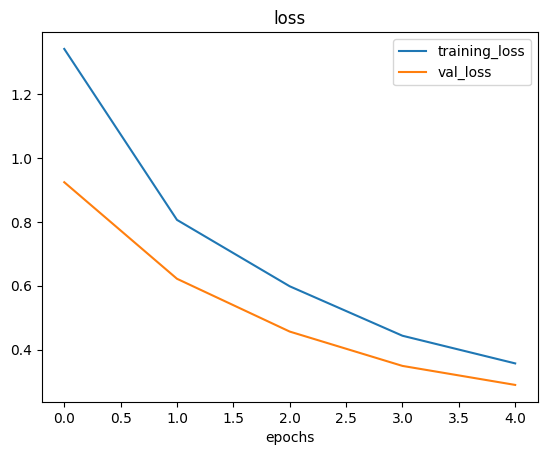

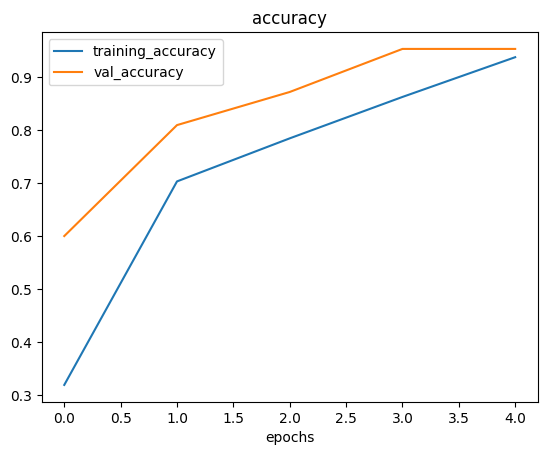

In [19]:
plot_loss_curves(history)

# Testing real data

Preprocessing gambar yang mau diliat

In [20]:
def load_and_prep_image(filename, img_shape = 224):
  img = tf.io.read_file(filename) #read image
  img = tf.image.decode_image(img) # decode the image to a tensor
  img = tf.image.resize(img, size = [img_shape, img_shape]) # resize the image
  img = img/255. # rescale the image
  return img

Fungsi buat predict label dari gambar yang dimasukin

In [21]:
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

Masukin gambar

In [22]:
image = '/content/depositphotos_354073708-stock-photo-macro-shot-arabica-coffee-been.jpg'

Panggil fungsi buat ngecek gambarnya

1/1 [==============================] - 1s 1s/step


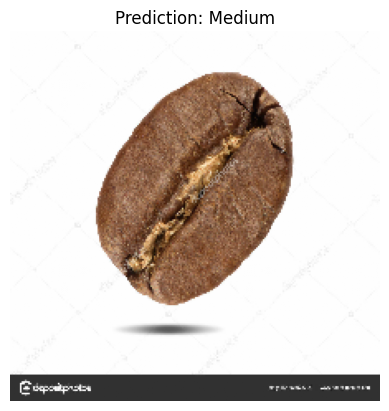

In [24]:
pred_and_plot(model, image, class_names)